In [1]:
import pandas as pd
import numpy as np

In [2]:
df3_sol = pd.read_csv('migration.csv', index_col='origin')
df3_sol

,North America,Central/South America,Africa,Europe,Oceania,Asia
origin,,,,,,
North America,96102,276908,63080,1242564,52303,297608
Central/South America,3627847,879198,22652,1764867,36031,162077
Africa,540887,12316,3832478,2108632,155988,681505
Europe,65649,16758,177326,2862931,127524,372138
Oceania,27137,1785,4747,171251,190706,33163
Asia,3725097,57782,242529,3372556,1000516,13182962


In [20]:
import numpy as np
from collections import Counter, defaultdict, OrderedDict
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import colormaps


def plot(input_data, *args, **kwargs):
    # This function plots the alluvial diagram
    # It allows the user to use this module without seeing its internals!!!!!!!!!!!!!!!!! It's magic!!!
    # TODO: Turn this function into a static method in AlluvialTool
    at = AlluvialTool(input_data, *args, **kwargs)
    ax = at.plot(**kwargs)
    ax.axis('off')
    return ax


class AlluvialTool:
    def _init_(
            self,
            input_data=(),
            x_range=(0, 1),
            res=20,
            h_gap_frac=0.03,
            v_gap_frac=0.03,
            **kwargs):
        # TODO: Break _init_ into several smaller sub-methods that do one thing each!
        # TODO: Turn all "getters" into setters or generate methods
        # TODO: Add documentation to methods
        self.input = input_data  # Describes pairs of labels from 2 categories (e.g. "country" - "spoken language")
        self.x_range = x_range  # Diagram coordinates in x-axis
        self.res = res  # Defines the number of spline points used to draw veins
        self.h_gap_frac = h_gap_frac  # Defines the horizontal distance between matplotlib patches (relative to x_range)
        self.v_gap_frac = v_gap_frac  # Defines the vertical distance between matplotlib patches (relative to max y)
        self.vein_blueprint = self.make_vein_blueprint_arrays()
        self.input_data_dict = self.read_input()  # TODO: Consider explicitly passing input_data
        self.item_width_dict = self.get_item_width_dict()
        self.src_group, self.dst_group = self.groups = self.get_ordered_label_groups(**kwargs)
        # TODO: get h_gap and v_gap from method/s
        self.h_gap = x_range[1] * h_gap_frac
        self.v_gap = sum(
            [width for b_item_counter in self.input_data_dict.values()
             for width in b_item_counter.values()]
        ) * v_gap_frac
        self.group_widths = self.get_group_widths()
        self.item_coord_dict = self.generate_item_coordinate_dict()
        self.alluvial_fan = self.generate_alluvial_fan()
        self.item_text_len, self.width_text_len = self.get_vein_label_lengths()

    def make_vein_blueprint_arrays(self):
        y = np.array([0, 0.15, 0.5, 0.85, 1])
        x = np.linspace(self.x_range[0], self.x_range[-1], len(y))
        z = np.polyfit(x, y, 4)
        f = np.poly1d(z)

        blueprint_x_vals = np.linspace(x[0], x[-1], self.res)
        blueprint_y_vals = f(blueprint_x_vals)
        return blueprint_x_vals, blueprint_y_vals

    def get_vein_polygon_xy(self, y_range, width):
        x, y = self.vein_blueprint
        y0, yn = y_range
        scale = yn - y0
        ty = y * scale + y0
        x_new = np.concatenate([x, x[::-1], ])
        y_new = np.concatenate([ty, ty[::-1] + width, ])
        return np.array([x_new, y_new]).transpose()

    def read_input_from_list(self):
        data_table = np.array(self.input)
        data_dic = defaultdict(Counter)
        for line in data_table:
            data_dic[line[0]][line[1]] += 1
        return data_dic

    def read_input_from_dict(self):
        # data_dic = self.input
        # data_table = []
        # for x_item, y_item_counter in data_dic.items():
        #     for y_item, count in y_item_counter.items():
        #         data_table += [[x_item, y_item]] * count
        # data_table = np.array(sorted(data_table))
        # return data_table, data_dic
        return self.input

    def read_input(self):
        if type(self.input) == dict:
            return self.read_input_from_dict()
        else:
            return self.read_input_from_list()

    def get_item_width_dict(self):
        iwd = Counter()  # item_width_dict
        for src_item_label, dst_width_dict in self.input_data_dict.items():
            for dst_item_label, width in dst_width_dict.items():
                iwd[src_item_label] += width
                iwd[dst_item_label] += width
        return iwd

    def get_ordered_label_groups(self, src_label_override=['North America', 'Europe', 'Central/South America', 'Asia', 'Africa', 'Oceania'], 
                                 dst_label_override=['Oceania', 'Central/South America', 'North America', 'Asia', 'Europe', 'Africa'], **kwargs):
        # TODO: Remove code duplication from creation of src, dst lists
        _ = kwargs

        src_ordered_labels = src_label_override if src_label_override else sorted(
            {src_item for src_item in self.input_data_dict}, key=lambda x: self.item_width_dict[x])

        dst_ordered_labels = dst_label_override if dst_label_override else sorted(
            {dst_item for dst_item_counter in self.input_data_dict.values() for dst_item in dst_item_counter},
            key=lambda x: self.item_width_dict[x])

        return src_ordered_labels, dst_ordered_labels

    def get_group_widths(self):
        return [self.get_group_width(group) for group in (self.src_group, self.dst_group)]

    def get_group_width(self, group):
        return sum([self.item_width_dict[item] for item in group]) + (len(group) - 1) * self.v_gap

    def generate_item_coordinate_dict(self, ):
        item_coord_dict = defaultdict(ItemCoordRecord)
        for ind, group in enumerate(self.groups):
            last_pos = (max(self.group_widths) - self.group_widths[ind]) / 2
            # TODO: Move inner for loop into a method
            for item in group:
                width = self.item_width_dict[item]
                xy = (self.x_range[ind], last_pos)
                item_coord_dict[item].set_start_state(width, xy, side=ind)
                last_pos += width + self.v_gap
        return item_coord_dict

    def generate_alluvial_vein(self, src_item, dst_item):
        # TODO: Move coordinate allocation from here to ItemCoordRecord and rename to allocator
        width = self.input_data_dict[src_item][dst_item]
        src_item_coord = self.item_coord_dict[src_item].read_state_and_advance_y(width)
        dst_item_coord = self.item_coord_dict[dst_item].read_state_and_advance_y(width)
        y_range = (src_item_coord[1], dst_item_coord[1],)
        return self.get_vein_polygon_xy(y_range, width)

    def get_label_rectangles_xy(self, a_item, b_item):
        width = self.input_data_dict[a_item][b_item]
        return (
            self.generate_item_sub_rectangle(a_item, width),
            self.generate_item_sub_rectangle(b_item, width),
        )

    def generate_item_sub_rectangle(self, item, width):
        dic_entry = self.item_coord_dict[item]
        item_coord = dic_entry.read_state()
        sign = dic_entry.get_side_sign()
        return self.get_rectangle_xy(item_coord, width, sign)

    def get_rectangle_xy(self, item_coord, width, sign):
        x, y = item_coord
        rect = [[
            x + sign * 0.5 * (0.5 + xa) * self.h_gap,
            y + ya * width,
        ] for xa, ya in ((0, 1), (0, 0), (1, 0), (1, 1))]
        return np.array(rect)

    def generate_alluvial_fan(self, ):
        alluvial_fan = OrderedDict()
        for src_item in self.src_group:
            dst_items_for_current_src_item = self.input_data_dict[src_item].keys()
            for dst_item in self.dst_group:
                if dst_item in dst_items_for_current_src_item:
                    src_label_rect, dst_label_rect = self.get_label_rectangles_xy(src_item, dst_item)
                    alluvial_fan[(src_item, dst_item)] = [
                        self.generate_alluvial_vein(src_item, dst_item),
                        src_label_rect,
                        dst_label_rect,
                    ]
        return alluvial_fan

    def plot(self, figsize=(10, 15), alpha=0.5, **kwargs):
        colors = self.get_color_array(**kwargs)
        fig, ax = plt.subplots(figsize=figsize)
        for ind, vein_items in enumerate(self.alluvial_fan.values()):
            patches = [Polygon(item, facecolor=colors[ind], alpha=alpha) for item in vein_items]
            for patch in patches:
                ax.add_patch(patch)
        self.auto_label_veins(**kwargs)
        self.label_sides(**kwargs)
        ax.autoscale()
        return ax

    def get_color_array(self, colors=None, color_side=0, rand_seed=1, cmap=None, **kwargs):
        _ = kwargs
        color_items = self.dst_group if color_side else self.src_group
        lci = len(color_items)
        if rand_seed is not None:
            np.random.seed(rand_seed)
        # Use specified colors for each item
        color_mapping = {
            'North America': '#07c8e3',
            'Europe': '#00da80',
            'Central/South America': '#ffbb18',
            'Asia': '#f60048',
            'Africa': '#00305d',
            'Oceania': '#5c2483',
        }
        color_array = [color_mapping[item] for item in color_items]
        polygon_colors = []
        for a_item, b_item, in self.alluvial_fan:
            item = b_item if color_side else a_item
            polygon_colors += [color_array[color_items.index(item)]]
        return np.array(polygon_colors)
    def get_vein_label_lengths(self):
        item_text_len = max([len(it) for it in self.item_width_dict], default=0)
        width_text_len = max([len(str(w)) for w in self.item_width_dict.values()], default=0)
        return item_text_len, width_text_len

    def auto_label_veins(self, fontname='Monospace', **kwargs):
        # shift = max([len(item) for item in self.item_coord_dic.keys()]) / 50
        for item, vein in self.item_coord_dict.items():
            y_width = vein.get_width()
            sign = vein.get_side_sign()
            side = int(sign + 1) // 2
            ha = 'left' if side else 'right'
            plt.text(
                vein.get_x() + 1.5 * sign * self.h_gap,
                vein.get_y() + y_width / 2,
                self.item_text(item, side, **kwargs),
                ha=ha, va='center', fontname=fontname)

    def label_sides(
            self,
            labels=None,
            label_shift=0,
            disp_width=False,
            wdisp_sep=7 * ' ',
            fontname='Arial',
            **kwargs):
        if labels is not None:
            _ = kwargs
            y = max(self.group_widths) / 2
            itl, wtl = self.item_text_len, self.width_text_len
            for side, sign in enumerate((-1, 1)):
                plt.text(
                    self.x_range[side] + sign * (
                            label_shift + itl + int(disp_width) * (len(wdisp_sep) + wtl))
                    * self.h_gap_frac,
                    y,
                    labels[side],
                    # bidi.algorithm.get_display(labels[side]),  # RTL languages
                    ha='center',
                    va='center',
                    fontname=fontname,
                    fontsize=16,
                    rotation=90 - 180 * side
                )

    def item_text(
            self, item, side,
            disp_width=False, wdisp_sep=7 * ' ', width_in=True, **kwargs):
        _ = kwargs
        f_item = item
        # f_item = bidi.algorithm.get_display(item)  # for RTL languages
        tal = '<' if f_item == item else '>'
        if not disp_width:
            ans = ('{:%s}' % tal).format(item)
        else:
            width = self.item_coord_dict[item].get_width()
            if side and width_in or (not side and not width_in):
                lc, rc, wl, wr, tl, tr = '>', tal, self.width_text_len, self.item_text_len, width, f_item,
            else:
                lc, rc, wl, wr, tl, tr = tal, '>', self.item_text_len, self.width_text_len, f_item, width,
            pat = '{:%s%d}%s{:%s%d}' % (lc, wl, wdisp_sep, rc, wr,)
            ans = pat.format(tl, tr, )
        return ans


class ItemCoordRecord:
    def _init_(self, ):
        self.width = 0
        self.xy = ()
        self.curr_xy = self.xy[:]
        self.side = -1

    def set_start_state(self, width, xy, side):
        self.width = width
        self.xy = xy
        self.curr_xy = list(self.xy[:])
        self.side = side

    def read_state_and_advance_y(self, width):
        out = self.curr_xy[:]
        self.curr_xy[1] += width
        return out

    def read_state_and_advance_x(self, width):
        out = self.curr_xy[:]
        self.curr_xy[0] += width
        return out

    def read_state(self):
        return self.curr_xy[:]

    def get_xy(self, ):
        return self.xy

    def get_x(self, ):
        return self.xy[0]

    def get_y(self, ):
        return self.xy[1]

    def get_width(self, ):
        return self.width

    def get_side_sign(self, ):
        return 1 if self.side else -1

    

import alluvial
import matplotlib.pyplot as plt
import numpy as np

input_data_dict = df3_sol.to_dict(orient='index')

# ax = alluvial.plot(input_data_dict)
# fig = ax.get_figure()
# fig.set_size_inches(5,5)
# plt.show()

# Create an instance of AlluvialTool with custom source and destination labels
alluvial_tool = AlluvialTool(input_data=input_data_dict)

#alluvial_tool = AlluvialTool(input_data=input_data_dict)
ax = alluvial_tool.plot(figsize=(6, 8), alpha=1)
ax.set_axis_off()


TypeError: AlluvialTool() takes no arguments

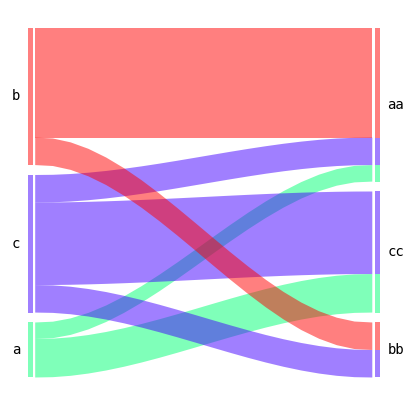

In [30]:
import alluvial
import matplotlib.pyplot as plt
import numpy as np

# input_data = {'a': {'aa': 0.3, 'cc': 0.7,},
#               'b': {'aa': 2, 'bb': 0.5,},
#               'c': {'aa': 0.5, 'bb': 0.5, 'cc': 1.5,}}

df3_sol_to_dict = df3_sol.to_dict(orient='index')

ax = alluvial.plot(input_data)
fig = ax.get_figure()
fig.set_size_inches(5,5)
plt.show()

In [28]:
import pandas as pd
from collections import defaultdict
from alluvial import AlluvialTool, plot

# Read the migration.csv dataset
df = pd.read_csv('migration.csv', index_col='origin')

# Prepare the data in the format required for AlluvialTool
input_data = defaultdict(dict)
for origin, row in df.iterrows():
    for destination, value in row.items():
        input_data[origin][destination] = value
        
input_data

# # Create an instance of AlluvialTool
# at = AlluvialTool(input_data)

# # Plot the alluvial diagram
# plot(input_data)


defaultdict(dict,
            {'North America': {'North America': 96102,
              'Central/South America': 276908,
              'Africa': 63080,
              'Europe': 1242564,
              'Oceania': 52303,
              'Asia': 297608},
             'Central/South America': {'North America': 3627847,
              'Central/South America': 879198,
              'Africa': 22652,
              'Europe': 1764867,
              'Oceania': 36031,
              'Asia': 162077},
             'Africa': {'North America': 540887,
              'Central/South America': 12316,
              'Africa': 3832478,
              'Europe': 2108632,
              'Oceania': 155988,
              'Asia': 681505},
             'Europe': {'North America': 65649,
              'Central/South America': 16758,
              'Africa': 177326,
              'Europe': 2862931,
              'Oceania': 127524,
              'Asia': 372138},
             'Oceania': {'North America': 27137,
              'Ce

In [31]:
df_sol3 = pd.read_csv('migration.csv', index_col='origin')
df_sol3.info()



<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, North America to Asia
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   North America          6 non-null      int64
 1   Central/South America  6 non-null      int64
 2   Africa                 6 non-null      int64
 3   Europe                 6 non-null      int64
 4   Oceania                6 non-null      int64
 5   Asia                   6 non-null      int64
dtypes: int64(6)
memory usage: 336.0+ bytes


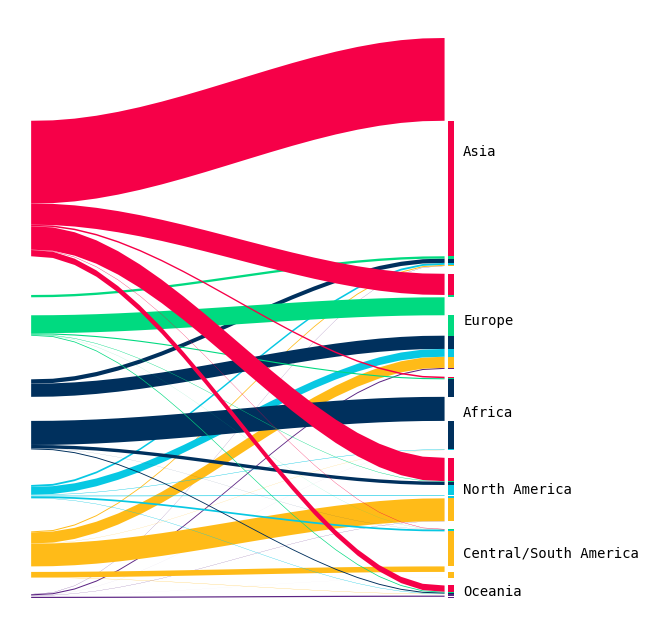

In [33]:
import numpy as np
from collections import Counter, defaultdict, OrderedDict
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import colormaps


def plot(input_data, *args, **kwargs):
    # This function plots the alluvial diagram
    # It allows the user to use this module without seeing its internals!!!!!!!!!!!!!!!!! It's magic!!!
    # TODO: Turn this function into a static method in AlluvialTool
    at = AlluvialTool(input_data, *args, **kwargs)
    ax = at.plot(**kwargs)
    ax.axis('off')
    return ax


class AlluvialTool:
    def __init__(
            self,
            input_data=(),
            x_range=(0, 1),
            res=20,
            h_gap_frac=0.03,
            v_gap_frac=0.03,
            **kwargs):
        # TODO: Break __init__ into several smaller sub-methods that do one thing each!
        # TODO: Turn all "getters" into setters or generate methods
        # TODO: Add documentation to methods
        self.input = input_data  # Describes pairs of labels from 2 categories (e.g. "country" - "spoken language")
        self.x_range = x_range  # Diagram coordinates in x-axis
        self.res = res  # Defines the number of spline points used to draw veins
        self.h_gap_frac = h_gap_frac  # Defines the horizontal distance between matplotlib patches (relative to x_range)
        self.v_gap_frac = v_gap_frac  # Defines the vertical distance between matplotlib patches (relative to max y)
        self.vein_blueprint = self.make_vein_blueprint_arrays()
        self.input_data_dict = self.read_input()  # TODO: Consider explicitly passing input_data
        self.item_width_dict = self.get_item_width_dict()
        self.src_group, self.dst_group = self.groups = self.get_ordered_label_groups(**kwargs)
        # TODO: get h_gap and v_gap from method/s
        self.h_gap = x_range[1] * h_gap_frac
        self.v_gap = sum(
            [width for b_item_counter in self.input_data_dict.values()
             for width in b_item_counter.values()]
        ) * v_gap_frac
        self.group_widths = self.get_group_widths()
        self.item_coord_dict = self.generate_item_coordinate_dict()
        self.alluvial_fan = self.generate_alluvial_fan()
        self.item_text_len, self.width_text_len = self.get_vein_label_lengths()

    def make_vein_blueprint_arrays(self):
        y = np.array([0, 0.15, 0.5, 0.85, 1])
        x = np.linspace(self.x_range[0], self.x_range[-1], len(y))
        z = np.polyfit(x, y, 4)
        f = np.poly1d(z)

        blueprint_x_vals = np.linspace(x[0], x[-1], self.res)
        blueprint_y_vals = f(blueprint_x_vals)
        return blueprint_x_vals, blueprint_y_vals

    def get_vein_polygon_xy(self, y_range, width):
        x, y = self.vein_blueprint
        y0, yn = y_range
        scale = yn - y0
        ty = y * scale + y0
        x_new = np.concatenate([x, x[::-1], ])
        y_new = np.concatenate([ty, ty[::-1] + width, ])
        return np.array([x_new, y_new]).transpose()

    def read_input_from_list(self):
        data_table = np.array(self.input)
        data_dic = defaultdict(Counter)
        for line in data_table:
            data_dic[line[0]][line[1]] += 1
        return data_dic

    def read_input_from_dict(self):
        # data_dic = self.input
        # data_table = []
        # for x_item, y_item_counter in data_dic.items():
        #     for y_item, count in y_item_counter.items():
        #         data_table += [[x_item, y_item]] * count
        # data_table = np.array(sorted(data_table))
        # return data_table, data_dic
        return self.input

    def read_input(self):
        if type(self.input) == dict:
            return self.read_input_from_dict()
        else:
            return self.read_input_from_list()

    def get_item_width_dict(self):
        iwd = Counter()  # item_width_dict
        for src_item_label, dst_width_dict in self.input_data_dict.items():
            for dst_item_label, width in dst_width_dict.items():
                iwd[src_item_label] += width
                iwd[dst_item_label] += width
        return iwd

    def get_ordered_label_groups(self, src_label_override=None, dst_label_override=None, **kwargs):
        # TODO: Remove code duplication from creation of src, dst lists
        _ = kwargs

        src_ordered_labels = src_label_override if src_label_override else sorted(
            {src_item for src_item in self.input_data_dict}, key=lambda x: self.item_width_dict[x])

        dst_ordered_labels = dst_label_override if dst_label_override else sorted(
            {dst_item for dst_item_counter in self.input_data_dict.values() for dst_item in dst_item_counter},
            key=lambda x: self.item_width_dict[x])

        return src_ordered_labels, dst_ordered_labels

    def get_group_widths(self):
        return [self.get_group_width(group) for group in (self.src_group, self.dst_group)]

    def get_group_width(self, group):
        return sum([self.item_width_dict[item] for item in group]) + (len(group) - 1) * self.v_gap

    def generate_item_coordinate_dict(self, ):
        item_coord_dict = defaultdict(ItemCoordRecord)
        for ind, group in enumerate(self.groups):
            last_pos = (max(self.group_widths) - self.group_widths[ind]) / 2
            # TODO: Move inner for loop into a method
            for item in group:
                width = self.item_width_dict[item]
                xy = (self.x_range[ind], last_pos)
                item_coord_dict[item].set_start_state(width, xy, side=ind)
                last_pos += width + self.v_gap
        return item_coord_dict

    def generate_alluvial_vein(self, src_item, dst_item):
        # TODO: Move coordinate allocation from here to ItemCoordRecord and rename to allocator
        width = self.input_data_dict[src_item][dst_item]
        src_item_coord = self.item_coord_dict[src_item].read_state_and_advance_y(width)
        dst_item_coord = self.item_coord_dict[dst_item].read_state_and_advance_y(width)
        y_range = (src_item_coord[1], dst_item_coord[1],)
        return self.get_vein_polygon_xy(y_range, width)

    def get_label_rectangles_xy(self, a_item, b_item):
        width = self.input_data_dict[a_item][b_item]
        return (
            self.generate_item_sub_rectangle(a_item, width),
            self.generate_item_sub_rectangle(b_item, width),
        )

    def generate_item_sub_rectangle(self, item, width):
        dic_entry = self.item_coord_dict[item]
        item_coord = dic_entry.read_state()
        sign = dic_entry.get_side_sign()
        return self.get_rectangle_xy(item_coord, width, sign)

    def get_rectangle_xy(self, item_coord, width, sign):
        x, y = item_coord
        rect = [[
            x + sign * 0.5 * (0.5 + xa) * self.h_gap,
            y + ya * width,
        ] for xa, ya in ((0, 1), (0, 0), (1, 0), (1, 1))]
        return np.array(rect)

    def generate_alluvial_fan(self, ):
        alluvial_fan = OrderedDict()
        for src_item in self.src_group:
            dst_items_for_current_src_item = self.input_data_dict[src_item].keys()
            for dst_item in self.dst_group:
                if dst_item in dst_items_for_current_src_item:
                    src_label_rect, dst_label_rect = self.get_label_rectangles_xy(src_item, dst_item)
                    alluvial_fan[(src_item, dst_item)] = [
                        self.generate_alluvial_vein(src_item, dst_item),
                        src_label_rect,
                        dst_label_rect,
                    ]
        return alluvial_fan

    def plot(self, figsize=(10, 15), alpha=0.5, **kwargs):
        colors = self.get_color_array(**kwargs)
        fig, ax = plt.subplots(figsize=figsize)
        for ind, vein_items in enumerate(self.alluvial_fan.values()):
            patches = [Polygon(item, facecolor=colors[ind], alpha=alpha) for item in vein_items]
            for patch in patches:
                ax.add_patch(patch)
        self.auto_label_veins(**kwargs)
        self.label_sides(**kwargs)
        ax.autoscale()
        return ax

    def get_color_array(self, colors=None, color_side=0, rand_seed=1, cmap=None, **kwargs):
        _ = kwargs
        color_items = self.dst_group if color_side else self.src_group
        lci = len(color_items)
        if rand_seed is not None:
            np.random.seed(rand_seed)
        # Use specified colors for each item
        color_mapping = {
            'North America': '#07c8e3',
            'Europe': '#00da80',
            'Central/South America': '#ffbb18',
            'Asia': '#f60048',
            'Africa': '#00305d',
            'Oceania': '#5c2483',
        }
        color_array = [color_mapping[item] for item in color_items]
        polygon_colors = []
        for a_item, b_item, in self.alluvial_fan:
            item = b_item if color_side else a_item
            polygon_colors += [color_array[color_items.index(item)]]
        return np.array(polygon_colors)

    def get_vein_label_lengths(self):
        item_text_len = max([len(it) for it in self.item_width_dict], default=0)
        width_text_len = max([len(str(w)) for w in self.item_width_dict.values()], default=0)
        return item_text_len, width_text_len

    def auto_label_veins(self, fontname='Monospace', **kwargs):
        # shift = max([len(item) for item in self.item_coord_dic.keys()]) / 50
        for item, vein in self.item_coord_dict.items():
            y_width = vein.get_width()
            sign = vein.get_side_sign()
            side = int(sign + 1) // 2
            ha = 'left' if side else 'right'
            plt.text(
                vein.get_x() + 1.5 * sign * self.h_gap,
                vein.get_y() + y_width / 2,
                self.item_text(item, side, **kwargs),
                ha=ha, va='center', fontname=fontname)

    def label_sides(
            self,
            labels=None,
            label_shift=0,
            disp_width=False,
            wdisp_sep=7 * ' ',
            fontname='Arial',
            **kwargs):
        if labels is not None:
            _ = kwargs
            y = max(self.group_widths) / 2
            itl, wtl = self.item_text_len, self.width_text_len
            for side, sign in enumerate((-1, 1)):
                plt.text(
                    self.x_range[side] + sign * (
                            label_shift + itl + int(disp_width) * (len(wdisp_sep) + wtl))
                    * self.h_gap_frac,
                    y,
                    labels[side],
                    # bidi.algorithm.get_display(labels[side]),  # RTL languages
                    ha='center',
                    va='center',
                    fontname=fontname,
                    fontsize=16,
                    rotation=90 - 180 * side
                )

    def item_text(
            self, item, side,
            disp_width=False, wdisp_sep=7 * ' ', width_in=True, **kwargs):
        _ = kwargs
        f_item = item
        # f_item = bidi.algorithm.get_display(item)  # for RTL languages
        tal = '<' if f_item == item else '>'
        if not disp_width:
            ans = ('{:%s}' % tal).format(item)
        else:
            width = self.item_coord_dict[item].get_width()
            if side and width_in or (not side and not width_in):
                lc, rc, wl, wr, tl, tr = '>', tal, self.width_text_len, self.item_text_len, width, f_item,
            else:
                lc, rc, wl, wr, tl, tr = tal, '>', self.item_text_len, self.width_text_len, f_item, width,
            pat = '{:%s%d}%s{:%s%d}' % (lc, wl, wdisp_sep, rc, wr,)
            ans = pat.format(tl, tr, )
        return ans


class ItemCoordRecord:
    def __init__(self, ):
        self.width = 0
        self.xy = ()
        self.curr_xy = self.xy[:]
        self.side = -1

    def set_start_state(self, width, xy, side):
        self.width = width
        self.xy = xy
        self.curr_xy = list(self.xy[:])
        self.side = side

    def read_state_and_advance_y(self, width):
        out = self.curr_xy[:]
        self.curr_xy[1] += width
        return out

    def read_state_and_advance_x(self, width):
        out = self.curr_xy[:]
        self.curr_xy[0] += width
        return out

    def read_state(self):
        return self.curr_xy[:]

    def get_xy(self, ):
        return self.xy

    def get_x(self, ):
        return self.xy[0]

    def get_y(self, ):
        return self.xy[1]

    def get_width(self, ):
        return self.width

    def get_side_sign(self, ):
        return 1 if self.side else -1


df_sol3 = pd.read_csv('migration.csv', index_col='origin')
input_data_dict = df_sol3.to_dict(orient='index')

# Create an instance of AlluvialTool with custom source and destination labels
alluvial_tool = AlluvialTool(input_data=input_data_dict)
    
# Plot the alluvial diagram
ax = alluvial_tool.plot(figsize=(6, 8), alpha=1)
ax.set_axis_off()
plt.show()
